In [1]:
# import flowpy
import numpy as np
import matplotlib.pyplot as plt
import cv2
# from benchmark_viper import VIPER
from util_flow import ReadKittiPngFile
from my_utils import imshow, visFlow, loadVisFlow, loadFlow, mergeFlow, backpropFlow, backpropFlowFilter, imageMap, backpropFlowFilter2, backpropFlowNoDup
from mmseg.core.evaluation import metrics
import numpy as np
import torch

/srv/flash1/skareer6/miniconda3/envs/mmseg/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def mesh_grid(B, H, W):
    x_base = torch.arange(0, W).repeat(B, H, 1)  # BHW
    y_base = torch.arange(0, H).repeat(B, W, 1).transpose(1, 2)  # BHW

    base_grid = torch.stack([x_base, y_base], 1)  # B2HW
    return base_grid

def norm_grid(v_grid):
    _, _, H, W = v_grid.size()

    v_grid_norm = torch.zeros_like(v_grid)
    v_grid_norm[:, 0, :, :] = 2.0 * v_grid[:, 0, :, :] / (W - 1) - 1.0
    v_grid_norm[:, 1, :, :] = 2.0 * v_grid[:, 1, :, :] / (H - 1) - 1.0
    return v_grid_norm.permute(0, 2, 3, 1)  # BHW2

In [3]:
def flow_warp(x, flow12, pad='border', mode='bilinear'):
    import torch.nn as nn
    B, _, H, W = x.size()

    base_grid = mesh_grid(B, H, W).type_as(x)  # B2HW

    v_grid = norm_grid(base_grid + flow12)  # BHW2
    if 'align_corners' in inspect.getfullargspec(torch.nn.functional.grid_sample).args:
        im1_recons = nn.functional.grid_sample(x, v_grid, mode=mode, padding_mode=pad, align_corners=True)
    else:
        im1_recons = nn.functional.grid_sample(x, v_grid, mode=mode, padding_mode=pad)
    return im1_recons

(1080, 1920, 2) (1080, 1920, 3)
(1080, 1920, 3)
[540 960]


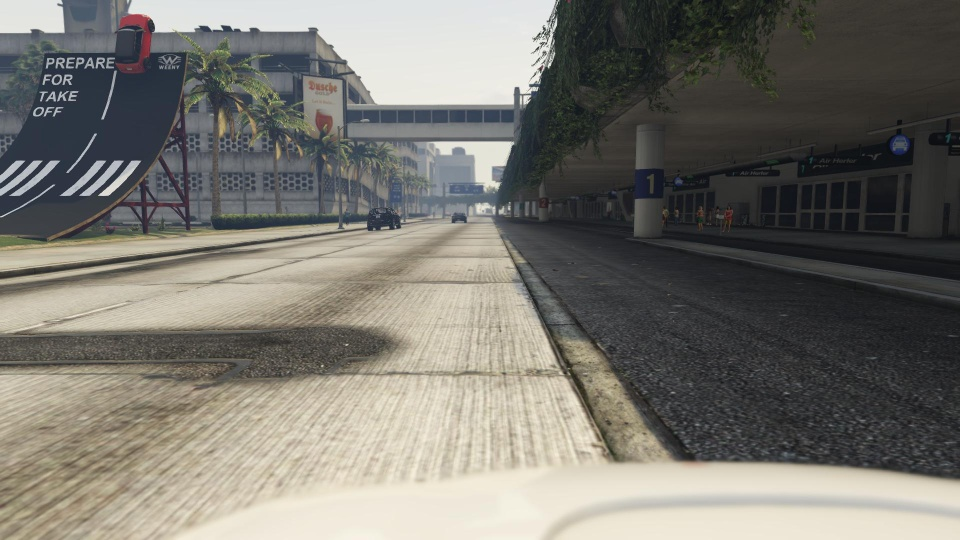

(1080, 1920, 3)
[540 960]


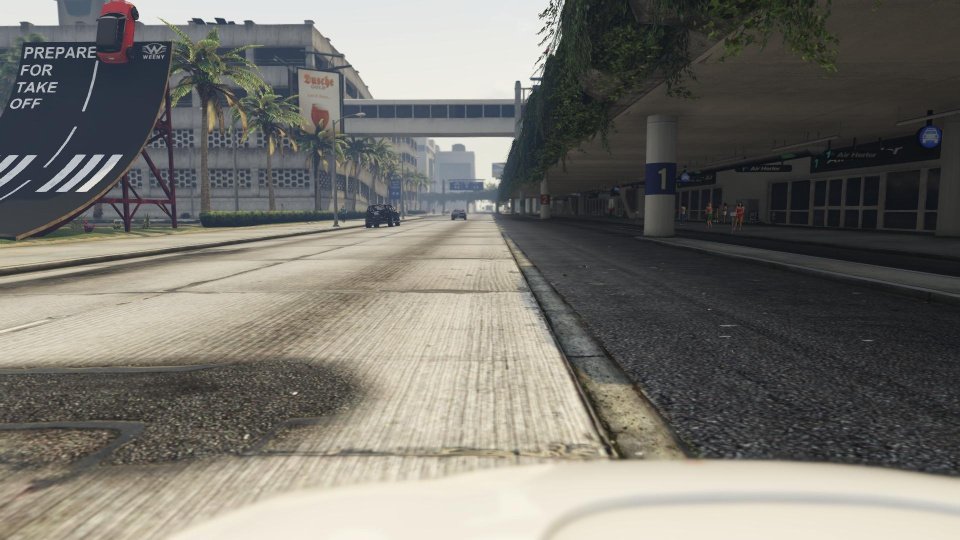

In [4]:
flow1 = loadFlow("/srv/share4/datasets/VIPER_Flowv2/val/flow_occ/001_0464.png")
flow2 = loadFlow("/srv/share4/datasets/VIPER_Flowv2/val/flow_occ/001_0465.png")
im1 = cv2.imread("/srv/share4/datasets/VIPER/val/img/001/001_00464.jpg")
im2 = cv2.imread("/srv/share4/datasets/VIPER/val/img/001/001_00465.jpg")
label1 = cv2.imread("/srv/share4/datasets/VIPER/val/cls/001/001_00464.png")
label2 = cv2.imread("/srv/share4/datasets/VIPER/val/cls/001/001_00465.png")
print(flow1.shape, im1.shape)
imshow(im1, scale=0.5)
imshow(im2, scale=0.5)

(1080, 1920, 3)
[540 960]


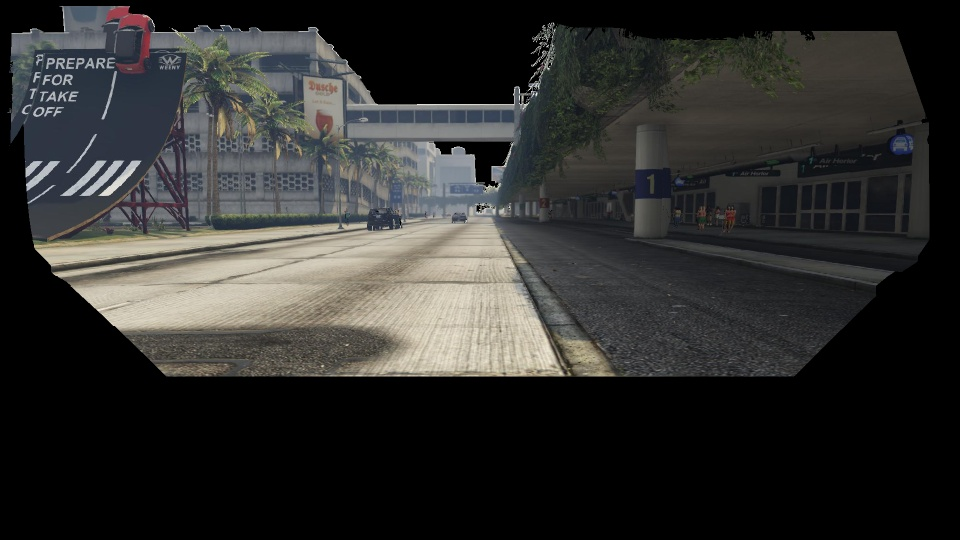

In [5]:
imshow(backpropFlow(flow1, im2), scale=0.5)

(1080, 1920, 3)
[540 960]


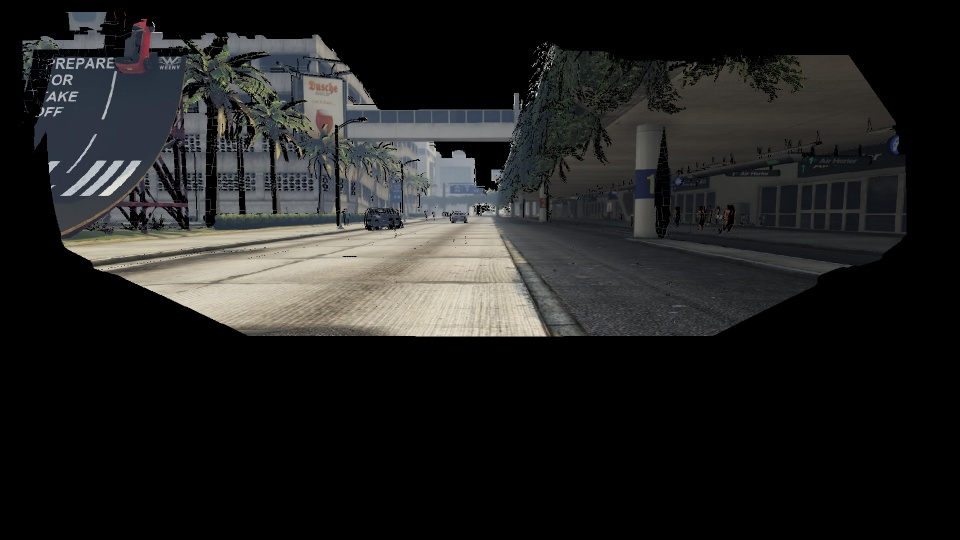

In [6]:
imshow(backpropFlowNoDup(flow1, im2), scale=0.5)

In [11]:
label2[:, :, [0]].shape

(1080, 1920, 1)

(1080, 1920, 1)
[540 960]


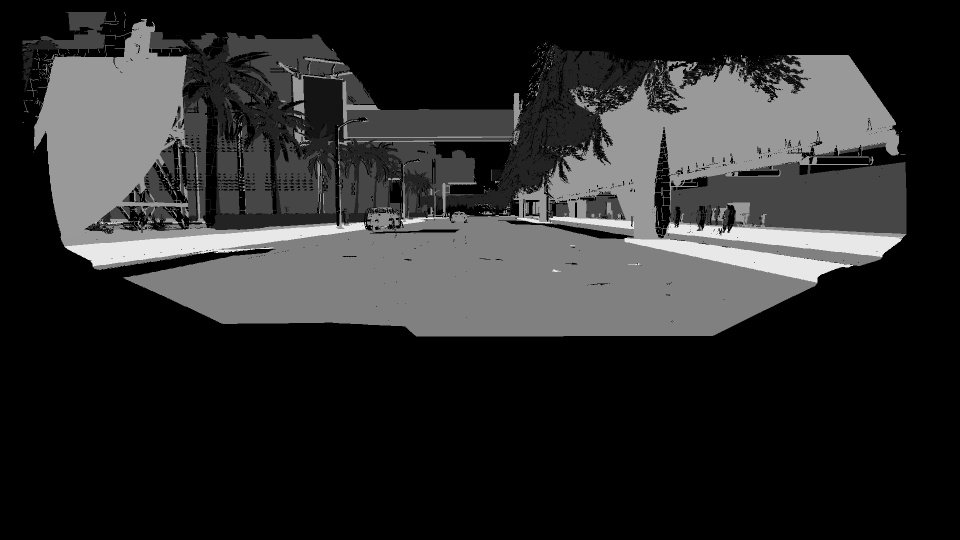

In [12]:
imshow(backpropFlowNoDup(flow1, label2[:, :, [0]]), scale=0.5)

### Other codebase

In [ ]:
import inspect
im2Tensor = torch.tensor(im2).unsqueeze(0).permute((0, 3, 1, 2)).float()
flow1Tensor = torch.tensor(flow1).unsqueeze(0).permute((0, 3, 1, 2)).float()
print(im2Tensor.shape, flow1Tensor.shape)

warped = flow_warp(torch.tensor(im2Tensor), torch.tensor(flow1Tensor), pad="zeros").numpy()
print("warp shape: ", warped.shape)

In [ ]:
imshow(warped.transpose(2, 3, 1, 0).squeeze(-1), scale=0.5)

In [8]:
#next let's load the labels, map to trainid, and calculate the miou between the label_t and backpropped label_{t+1}

In [ ]:
imshow(label1, scale=0.5)

In [ ]:
label2_1 = backpropFlow(flow1, label2)
imshow(label2_1, scale=0.5)

## Calc mIoU now

In [7]:
# palette_to_id = [
#     ([128, 64, 128], 0),
#     ([244, 35, 232], 1),
#     ([70, 70, 70], 2),
#     ([102, 102, 156], 3),
#     ([190, 153, 153], 4),
#     ([153, 153, 153], 5),
#     ([250, 170, 30], 6),
#     ([220, 220, 0], 7),
#     ([107, 142, 35], 8),
#     ([152, 251, 152], 9),
#     ([70, 130, 180], 10),
#     ([220, 20, 60], 11),
#     ([255, 0, 0], 12),
#     ([0, 0, 142], 13),
#     ([0, 0, 70], 14),
#     ([0, 60, 100], 15),
#     ([0, 80, 100], 16),
#     ([0, 0, 230], 17),
#     ([119, 11, 32], 18),
# ]
palette_to_id = [   
    ([0,0,0], 0),
    ([111,74,0], 1),
    ([70,130,180], 2),
    ([128,64,128], 3),
    ([244,35,232], 4),
    ([230,150,140], 5),
    ([152,251,152], 6),
    ([87,182,35], 7),
    ([35,142,35], 8),
    ([70,70,70], 9),
    ([153,153,153], 10),
    ([190,153,153], 11),
    ([150,20,20], 12),
    ([250,170,30], 13),
    ([220,220,0], 14),
    ([180,180,100], 15),
    ([173,153,153], 16),
    ([168,153,153], 17),
    ([81,0,21], 18),
    ([81,0,81], 19),
    ([220,20,60], 20),
    ([255,0,0], 21),
    ([119,11,32], 22),
    ([0,0,230], 23),
    ([0,0,142], 24),
    ([0,80,100], 25),
    ([0,60,100], 26),
    ([0,0,70], 27),
    ([0,0,90], 28),
    ([0,80,100], 29),
    ([0,100,100], 30),
    ([50,0,90], 31)
]

In [8]:
test_im = np.array(
    [[[ 1.,  1.,  1.],
        [ 1., 1.,  1.],
        [ 1.,  1.,  3.]],
       [[ 1.,  1.,  1.],
        [ 1., 2.,  1.],
        [ 1.,  1.,  3.]]]
)
test_map = [
   ([1., 2], 5.),
   ([3., 3], 10.)
]
print(test_im.shape)

imageMap(test_im.transpose((1, 2, 0)), test_map)

(2, 3, 3)


array([[[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 5.,  5.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [10., 10.]]])

In [9]:
label1 = cv2.cvtColor(label1, cv2.COLOR_BGR2RGB)
label2 = cv2.cvtColor(label2, cv2.COLOR_BGR2RGB)
mlabel1 = imageMap(label1, palette_to_id)
mlabel2 = imageMap(label2, palette_to_id)

In [10]:
np.unique(mlabel2)

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 14, 19, 20, 24],
      dtype=uint8)

In [11]:
# now that I have the translated labels.  Backprop label2 onto label1 and calculate miou

In [12]:
mlabel2_1 = backpropFlow(flow1, mlabel2)
intersect, union, _, _ = metrics.intersect_and_union(mlabel1, mlabel2_1, num_classes=31, ignore_index=0)

In [13]:
intersect/union

tensor([0.0000, 0.9617, 0.0000, 0.9888, 0.9543,    nan, 0.8632, 0.7271, 0.8134,
        0.8625, 0.8839, 0.0000, 0.9457,    nan, 0.8923,    nan,    nan,    nan,
           nan, 0.7119, 0.5948,    nan,    nan,    nan, 0.8400,    nan,    nan,
           nan,    nan,    nan,    nan])

In [14]:
np.isnan((intersect/union)[5].item())

True

In [15]:
def formatmIoU(miou, names, print_na=False):
    cml_sum = 0
    count = 0
    for val, name in zip(miou, names):
        val=val.item()
        if not np.isnan(val) or print_na:
            print(f"{name:15s}: {val*100:2.2f}")
        if not np.isnan(val):
            cml_sum += val
            count += 1
    
    # print("HI: ", cml_sum)
    print(f"{'mean':15s}: {cml_sum*100/count:2.2f}")

In [16]:
# CLASSES = ('road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle')
CLASSES = ("unlabeled", "ambiguous", "sky","road","sidewalk","railtrack","terrain","tree","vegetation","building","infrastructure","fence","billboard","trafficlight","trafficsign","mobilebarrier","firehydrant","chair","trash","trashcan","person","animal","bicycle","motorcycle","car","van","bus","truck","trailer","train","plane","boat")

formatmIoU(intersect/union, CLASSES)

unlabeled      : 0.00
ambiguous      : 96.17
sky            : 0.00
road           : 98.88
sidewalk       : 95.43
terrain        : 86.32
tree           : 72.71
vegetation     : 81.34
building       : 86.25
infrastructure : 88.39
fence          : 0.00
billboard      : 94.57
trafficsign    : 89.23
trashcan       : 71.19
person         : 59.48
car            : 84.00
mean           : 69.00


## Now for 10 frames

In [17]:
im1 = cv2.imread("/srv/share4/datasets/VIPER/val/img/001/001_00461.jpg")
im9 = cv2.imread("/srv/share4/datasets/VIPER/val/img/001/001_00469.jpg")
label1 = cv2.imread("/srv/share4/datasets/VIPER/val/cls/001/001_00461.png")
label9 = cv2.imread("/srv/share4/datasets/VIPER/val/cls/001/001_00469.png")

In [18]:
cmlFlow = loadFlow("/srv/share4/datasets/VIPER_Flowv2/val/flow_occ/001_0461.png")
for i in range(8):
    flowi = loadFlow(f"/srv/share4/datasets/VIPER_Flowv2/val/flow_occ/001_0{462+i}.png")
    cmlFlow = mergeFlow(cmlFlow, flowi)

(1080, 1920, 3)
[540 960]


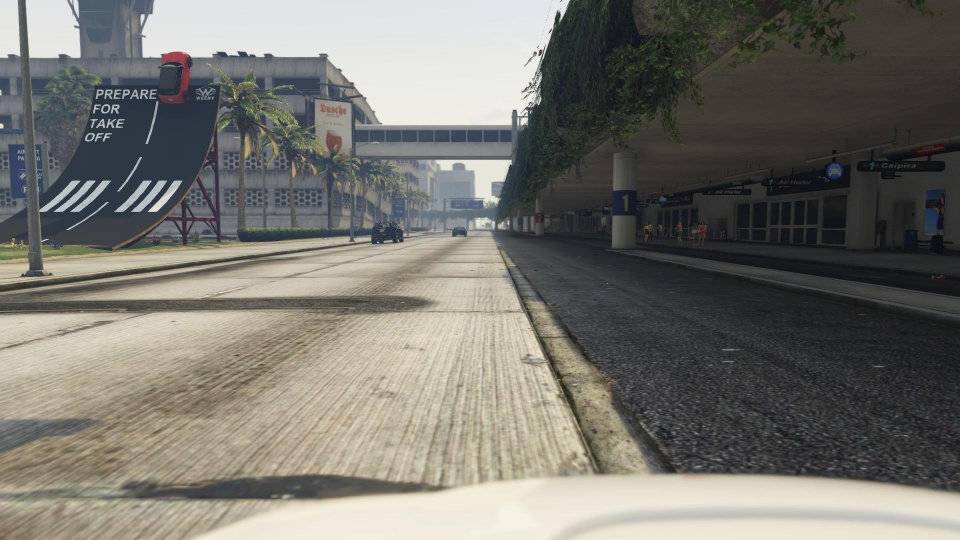

In [19]:
imshow(im1, scale=0.5)

(1080, 1920, 3)
[540 960]


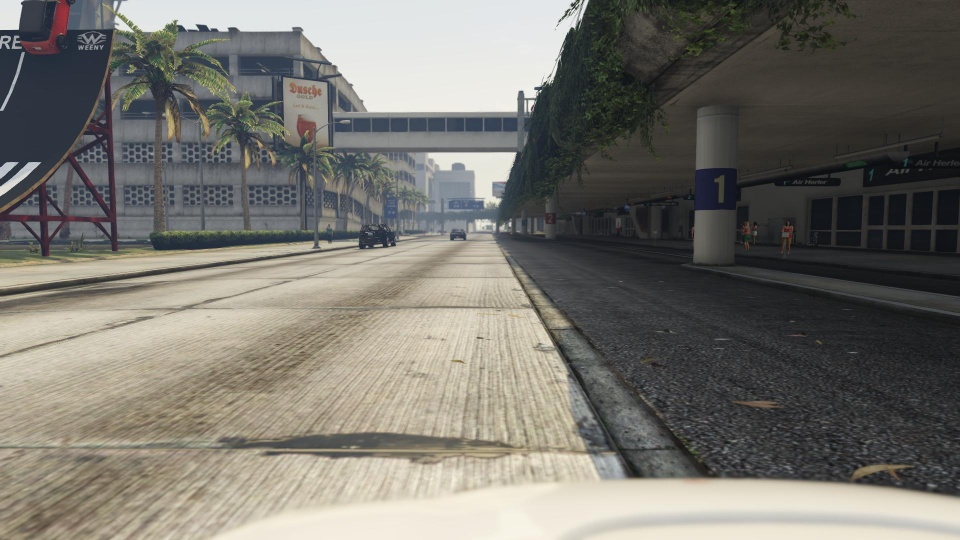

In [20]:
imshow(im9, scale=0.5)

(1080, 1920, 3)
[540 960]


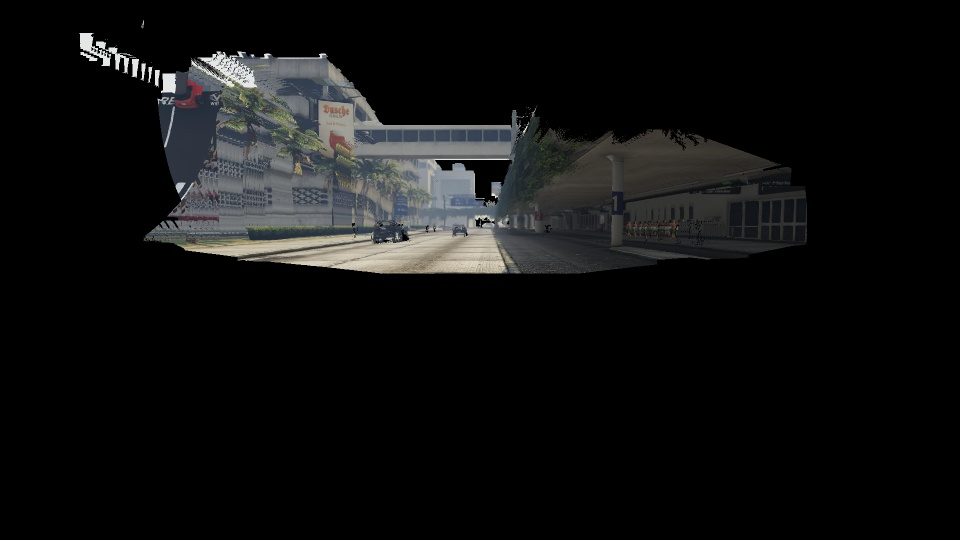

In [21]:
imshow(backpropFlow(cmlFlow, im9), scale=0.5)

In [22]:
label1 = cv2.cvtColor(label1, cv2.COLOR_BGR2RGB)
label9 = cv2.cvtColor(label9, cv2.COLOR_BGR2RGB)
mlabel1 = imageMap(label1, palette_to_id)
mlabel9 = imageMap(label9, palette_to_id)

In [23]:
mlabel9_1 = backpropFlow(flow1, mlabel9)
intersect, union, _, _ = metrics.intersect_and_union(mlabel9, mlabel9_1, num_classes=31, ignore_index=0)

In [24]:
formatmIoU(intersect/union, CLASSES)

unlabeled      : 0.00
ambiguous      : 37.61
sky            : 57.46
road           : 95.41
sidewalk       : 72.92
terrain        : 38.20
tree           : 34.45
vegetation     : 60.51
building       : 60.28
infrastructure : 68.27
fence          : 0.00
billboard      : 63.91
trafficsign    : 46.93
mobilebarrier  : 0.00
trashcan       : 0.00
person         : 4.03
car            : 53.22
mean           : 40.78
